### Introduction

Suppose we have a bunch of URLs and we want to know their adult-rating
(i.e., is the url P, or G, or X, or R). This task is difficult for
computers, but easy for humans, and this has led to the growth of
crowdsourcing: get a bunch of humans to give ratings to urls, but
use automated techniques to figure out how much to trust each person's
ratings.

We are going to use the data from a paper by Ipeirotis *et al.*
This details an experiment run on Amazon's *Mechanical Turk* crowdsourcing system.
They ask a bunch of raters (called "turks") to rate several urls,
but they already know the answers (the true categories) for a few
urls, called the **gold set**. The ratings of the turks on the gold
set thus allows us to judge their accuracy.

### [Q1 10 points] Read in data}
Read in the files **gold.txt** and **labels.txt**.  The **gold**
DataFrame should have columns `url` and `category`, while the
**labels** DataFrame should have columns `turk`, `url` and
`category`. You will have to pick the right separator.

In [19]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

gold = pd.read_csv('gold.txt',sep='\t',header=None,names=['url', 'category'])
labels = pd.read_csv('labels.txt',sep = '\t',header= None, names=['turk','url', 'category'])

gold[:5]
labels[:5]

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


,turk,url,category
0,A1OT3A29R9N1DG,http://000.cc,P
1,A1PXXEOGQ76RNJ,http://000.cc,G
2,A1PXXEOGQ76RNJ,http://000.cc,G
3,A21US576U8SCO4,http://000.cc,G
4,A2LGX47NN7C5D3,http://000.cc,G


### [Q2 10 points] Split into two DataFrames
Split the **labels** DataFrame into two:
* **labels_on_gold**, containing all rows where the url is present in the gold set, and
* **labels_unknown**, containing all the remaining rows of **labels**.

In [20]:
on_gold = labels['url'].isin(gold['url'])
labels_on_gold = labels[on_gold].drop_duplicates()
#contains the gold set urls

labels_unknown = labels[~on_gold].drop_duplicates()
#contain the urls not found in the gold set

### [Q3 10 points] Compute accuracies of turks
Create a **rater_goodness** DataFrame that is indexed by turk, and
has two columns: the number of ratings, and the average correctness of
ratings for each turk (both on gold set urls).

In [35]:
correct_ratings = labels_on_gold.merge(gold,
                                      left_on = 'url',
                                      right_on = 'url',
                                      suffixes=['_turk','_gold'])
#merged on 'url'

correct = correct_ratings['category_turk'] == correct_ratings['category_gold']
#verify turk accuracy by comparing the columns and add to the correctness ['Bingo'] column

correct_ratings['Bingo'] = correct
correct_ratings[:10]


pandas.core.series.Series

In [34]:
correctness = correct_ratings[['turk','Bingo']]
#use 'Bingo' column to create 'correctness' dataframe
#group by turk and find the mean (average correctness of ratings per turk)

correctness = correctness.groupby('turk').mean()
correctness[:5]


,Bingo
turk,
A112DVP1KG4QZU,1.000000
A1253FXHCZ9CWM,0.517241
A12CY1Q7XKJJDE,1.000000
A12RE8G66WTO8B,0.750000
A12Y1GTGIQDGRA,0.333333


In [42]:
num_ratings = DataFrame(correct_ratings.groupby('turk')['category_turk'].count())
#group by turk and count up the number of ratings per turk

num_ratings[:5]


,category_turk
turk,
A112DVP1KG4QZU,1
A1253FXHCZ9CWM,29
A12CY1Q7XKJJDE,1
A12RE8G66WTO8B,20
A12Y1GTGIQDGRA,3


In [41]:
rater_goodness = correctness.merge(num_ratings,left_on = 'turk',right_on = 'turk')
#merge num_ratings and correctness to one dataframe rater_goodness
#merge on 'turk' to set index by turk

rater_goodness.columns = ['average correctness of ratings','number of ratings'] 
#create new columns to hold correctness and number of ratings within 'rater_goodness'

#change the column name
rater_goodness[:10]

,average correctness of ratings,number of ratings
turk,,
A112DVP1KG4QZU,1.000000,1
A1253FXHCZ9CWM,0.517241,29
A12CY1Q7XKJJDE,1.000000,1
A12RE8G66WTO8B,0.750000,20
A12Y1GTGIQDGRA,0.333333,3
A13CEW9JGDWGX1,1.000000,1
A13OE9GBRJ0S2U,0.750000,4
A14IQ4GLNWNPOJ,1.000000,1
A153PKAL7OAY36,0.722973,148


### [Q4 10 points] Odds ratios}
If someone is correct $p$ fraction of the time, the `odds` of
success are defined as:

$$\mbox{odds} = \frac{p}{1.001-p}.$$

Attach a column called `odds` to the **rater_goodness** DataFrame, using the average correctness of the turk as his or her $p$.

In [43]:
#define a function to parse through rater_goodness and calculate 'odds'
def odds_ratios(s):
    odds = s*1.0 / (1.001-s)
    return odds

#apply 'odds_ratios' function and store the calculations in the column 'odds'
rater_goodness['odds'] = rater_goodness['average correctness of ratings'].map(odds_ratios)
rater_goodness[:10]

,average correctness of ratings,number of ratings,odds
turk,,,
A112DVP1KG4QZU,1.000000,1,1000.000000
A1253FXHCZ9CWM,0.517241,29,1.069214
A12CY1Q7XKJJDE,1.000000,1,1000.000000
A12RE8G66WTO8B,0.750000,20,2.988048
A12Y1GTGIQDGRA,0.333333,3,0.499251
A13CEW9JGDWGX1,1.000000,1,1000.000000
A13OE9GBRJ0S2U,0.750000,4,2.988048
A14IQ4GLNWNPOJ,1.000000,1,1000.000000
A153PKAL7OAY36,0.722973,148,2.600369


### [Q5 10 points] Most accurate turks
List the top 10 most accurate turks who have rated at least 20 gold set URLs.

In [24]:
#list the top 20 who rated at least 20 gold set urls based on number of ratings in 'rater_goodness' dataframe
at_least_20 = rater_goodness['number of ratings'] >= 20

#sort by 'average correctness of ratings' in descending order to identify the top 10
rater_goodness[at_least_20].sort_values(by='average correctness of ratings',ascending = False)[:10]

,average correctness of ratings,number of ratings,odds,number
turk,,,,
A2U0R4X38GUKZE,0.950000,20,18.627451,20
A22C0PJUBFJTI0,0.916667,36,10.869565,36
A23YQUBXZPKILZ,0.875000,24,6.944444,24
ATVALOQVDCMZW,0.854369,103,5.826657,103
A1HIXWH4OXT8S4,0.825000,40,4.687500,40
A3220HG1O83HQ4,0.818182,22,4.475385,22
A32W20KGQXS0LL,0.800000,25,3.980100,25
A20PWAB7G3HDHU,0.800000,20,3.980100,20
AJSJVK40F5HM6,0.785714,28,3.649635,28


### [Q6 10 points] Rating counts versus accuracy
One may imagine that a committed and accurate turk will rate lots of
URLs. On the other hand, perhaps it is only the spammers who have the
time to rate lots of URLs.

Is number of ratings by a turker on gold set URLs related to his or
her accuracy? There's no fixed answer; just try to show some evidence
for your answer.

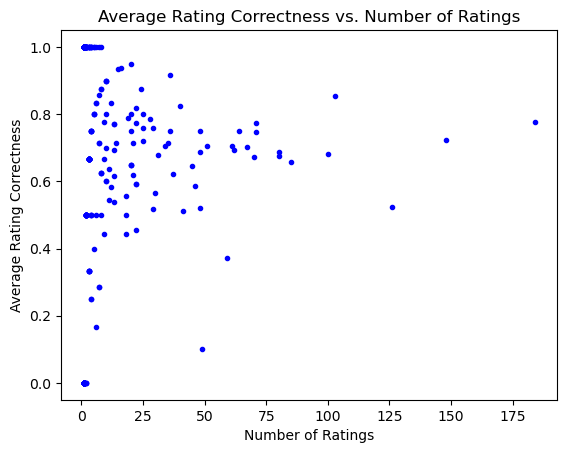

Correlation Coefficient: 0.04498264044141277
                            OLS Regression Results                            
Dep. Variable:                   odds   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     26.77
Date:                Wed, 02 Aug 2023   Prob (F-statistic):           4.52e-07
Time:                        07:57:09   Log-Likelihood:                -2019.6
No. Observations:                 269   AIC:                             4043.
Df Residuals:                     267   BIC:                             4050.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Interce

In [25]:
import statsmodels.api as sm
from patsy import dmatrices

# Plot number of ratings against avg correctness to check if there exists a correlation
plot(rater_goodness['number of ratings'], rater_goodness['average correctness of ratings'], marker='.', color='blue', linestyle='None')
xlabel('Number of Ratings')
ylabel('Average Rating Correctness')
title('Average Rating Correctness vs. Number of Ratings')
show()

# Calculate the correlation coefficient between the number of ratings and average correctness
corr_coeff = rater_goodness['number of ratings'].corr(rater_goodness['average correctness of ratings'])

print("Correlation Coefficient:", corr_coeff)


rater_goodness['number'] = rater_goodness['number of ratings']
y, X = dmatrices('odds ~ number', data=rater_goodness, return_type='dataframe')
model = sm.OLS(y, X)
result = model.fit()
print(result.summary())

Based on the plot, we observe that there is no strong correlation between the number of ratings and the average correctness. Some turks rated a substantial number of URLs but achieved lower average correctness, while others with fewer ratings demonstrated higher average correctness.

Interestingly, a cluster of turks who rated a moderate number of URLs (around 20 to 100) displayed relatively high average correctness. This suggests that moderate commitment from turks might contribute to higher accuracy.

In conclusion, we cannot definitively state whether the number of ratings a turk provides on gold set URLs is directly related to their accuracy. The relationship appears to be more intricate, likely influenced by other unexplored factors.

### [Q7 13 points] Overall predicted odds}

Let $u$ denote any url $u$ that is *not* in the gold set, and let $c$ denote some category. 

* For every valid pair $(u, c)$, calculate the product of odds of all turks who satisfy the following two conditions: 
    1. the turk rated url $u$ as category $c$, and 
    2. he/she rated more gold set urls than 75% of all turks who rated at least one gold-set url.

For example, if you find that there are 269 turks who rated at least
one gold-set url, you want to select only the turks who have rated
more gold-set urls than 75% of these 269 turks. We can think of
these as our *"reliable"* turks. Now, our belief that url $u$ belongs
to category $c$ depends on how many reliable turks rated $u$ as $c$;
specifically, our belief is based on the product of their reliability
scores (i.e., their odds).

We shall call such products of odds the **overall odds** henceforth.

In [49]:
#create a mask to filter OUT the turks that have NOT rated more gold set urls than 75% of all turks who rated at least one
url_75=rater_goodness['number of ratings']>(rater_goodness['number of ratings'].quantile(0.75))

#apply the mask to 'rater_goodness' and create a new dataframe
url_75_turks=rater_goodness[url_75]

#merge 'labels_unknown' and 'url_75_turks' to compare turk ratings of 'u' and 'c'
#merge on 'turk'
labels_unknown_odds=labels_unknown.merge(url_75_turks,left_on='turk',right_on='turk', how='left')

#drop null values to get rid of NaN values
labels_unknown_odds = labels_unknown_odds.dropna()
labels_unknown_odds[:5]

,turk,url,category,average correctness of ratings,number of ratings,odds
1,A1PXXEOGQ76RNJ,http://000.cc,G,0.512195,41.0,1.047852
2,A21US576U8SCO4,http://000.cc,G,0.586957,46.0,1.417620
9,A1PXXEOGQ76RNJ,http://0000.jp,G,0.512195,41.0,1.047852
10,A1XFA0A9Z3LAZJ,http://0000.jp,G,0.789474,19.0,3.732272
11,A21US576U8SCO4,http://0000.jp,G,0.586957,46.0,1.417620


In [50]:
#create a new dataframe called 'overall_odds' using 'labels_unknown_odds'
#group by 'url', 'catgory' and use the aggregation function to find the product of odds
overall_odds=DataFrame(labels_unknown_odds.groupby(['url','category'])['odds'].agg(np.prod))

overall_odds.columns = ['overall odds'] #change the column name
overall_odds[:10]

overall odds
url                                                category              
http://0-101.net                                   G             2.297602
http://000.cc                                      G             1.485456
http://0000.jp                                     G            14.339248
http://000relationships.com                        G             3.841962
                                                   P             1.851852
http://000vitamins.com                             G             4.033641
http://000webhost.com                              G            11.892639
http://003my.com                                   G             4.861524
http://007absolutehardcore.com/early_cumshots/i... P             3.346522
                                                   R            12.290450

### [Q8 13 points] Predicted categories
Create a DataFrame called **result_75**, with the following characteristics:
* its index is URLs not in the gold set,
* it has two columns:
    * `top category`: the category with the highest overall odds for that url, and
    * `top odds`: the overall odds for that top category.

These are our predictions, and the confidence we have in them (higher
overall odds implies greater confidence). If you want, you can
check to see if the predicted categories make sense.

In [27]:
#reshape the 'overall_odds' dataframe
category_unstack = overall_odds.unstack('category')

#transpose and find the index of the max value (most frequently occuring) in 'category' for each 'url'
top_category = DataFrame(category_unstack['overall odds'].T.idxmax())
top_category[:10]

,0
url,
http://0-101.net,G
http://000.cc,G
http://0000.jp,G
http://000relationships.com,G
http://000vitamins.com,G
http://000webhost.com,G
http://003my.com,G
http://007absolutehardcore.com/early_cumshots/index.html,X
http://007swz.cn,G


In [28]:
#transpose and find the index of the max value of 'overall odds' from each 'category' for each 'url'
top_odds = DataFrame(category_unstack['overall odds'].T.max())
top_odds[:10]

,0
url,
http://0-101.net,2.297602
http://000.cc,1.485456
http://0000.jp,14.339248
http://000relationships.com,3.841962
http://000vitamins.com,4.033641
http://000webhost.com,11.892639
http://003my.com,4.861524
http://007absolutehardcore.com/early_cumshots/index.html,293.252871
http://007swz.cn,1.485456


In [29]:
#merge to create the final dataframe including both top odds and category
result_75 = top_category.merge(top_odds,left_on = 'url',right_on = 'url')
result_75.columns=['top category','top odds'] #rename the columns
result_75[:10]

,top category,top odds
url,,
http://0-101.net,G,2.297602
http://000.cc,G,1.485456
http://0000.jp,G,14.339248
http://000relationships.com,G,3.841962
http://000vitamins.com,G,4.033641
http://000webhost.com,G,11.892639
http://003my.com,G,4.861524
http://007absolutehardcore.com/early_cumshots/index.html,X,293.252871
http://007swz.cn,G,1.485456


### [Q9 14 points] Predicted categories using more turks
Questions 7 and 8 above only considered the ratings of turks who had
rated enough gold set URLs, so we were relatively more confident about
their accuracies. What happens if we loosen this restriction?

Repeat the code of Q7 and Q8, but replacing 75% by 25% in the description of Q7 (i.e., we also consider turks who have far fewer gold set ratings).
Call this **result_25**.

Now let's see how these two results compare. 
Create a DataFrame where both the index and the columns are the
various categories, and the cells contain the number of urls with
these as the top categories according to **result_75** and **result_25**.

For example, the cell corresponding to the row `category=R`
and the column `category=G` would be the number of URLs that were predicted to
be *R* by **result_75** but predicted to be *G* by **result_25**.

Where are the most errors?

In [30]:
url_25=rater_goodness['number of ratings']>rater_goodness['number of ratings'].quantile(0.25)
url_25_turks=rater_goodness[url_25]
labels_unknown_odds_25=labels_unknown.merge(url_25_turks,left_on='turk',right_on='turk')

overall_odds_25=DataFrame(labels_unknown_odds_25.groupby(['url','category'])['odds'].agg(np.prod))
overall_odds_25.columns = ['overall odds']

In [31]:
category_unstack_25 = overall_odds_25.unstack('category')
top_category_25 = DataFrame(category_unstack_25['overall odds'].T.idxmax())
top_odds_25 = DataFrame(category_unstack_25['overall odds'].T.max())
result_25 = top_category_25.merge(top_odds_25,left_on = 'url',right_on = 'url')
result_25.columns=['top category','top odds']

In [32]:
merge_75_25 = result_75.merge(result_25,
                              left_on = 'url',
                              right_on = 'url',
                              suffixes = ['_75','_25'])

most_errors = pd.crosstab(merge_75_25['top category_75'],merge_75_25['top category_25'])
most_errors

top category_25,G,P,R,X
top category_75,,,,
G,8280,586,180,214
P,196,352,52,25
R,22,34,127,25
X,28,5,28,456


The cells in the most_errors DataFrame represent the number of URLs that were predicted to belong to specific categories by result_75 (where the top turks with higher ratings were considered) but were predicted to belong to different categories by result_25. Considering turks with fewer ratings in result_25 introduced misclassifications in categories P and R.